In [70]:
import itertools
import numpy as np
import pandas as pd

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import roc_curve
import xgboost as xgb

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [71]:
seed = 999 # seed to generate random numbers

# Index
* [Load the data](#Load-the-data)
* [Generate target](#Generate-target)
* [Feature Engineering](#Feature-Engineering)
    * [Dealing previous loan history](#Dealing-previous-loan-history)
    * [Employment information](#Employment-status-and-salary)
    * [One-Hot-Encoding features](#One-Hot-Encoding-purpose)
* [Train the model](#Train-the-model)
* [Choose best probability cutoff](#Choose-best-probablity-cutoff)
* [Re-train the model with all training data](#Re-train-the-model-with-all-training-data)
* [Test](#Test)
* [Feature importance](#Feature-importance)
* [Extra useful features](#Extra-useful-features)
* Answer Questions
    * [Answer question 2](#Test)
    * [Answer question 3](#q3)
    * [Answer question 4](#Extra-useful-features)

## Load the data

In [72]:
loan = pd.read_csv("loan_table.csv",index_col='loan_id')
# rename columns to short name, which is easier to visualize
loan.rename(columns={'loan_purpose':'purpose',
                     'loan_granted':'granted',
                     'loan_repaid':'repaid'},inplace=True)
loan['date'] = pd.to_datetime(loan.date)

In [73]:
borrower = pd.read_csv("borrower_table.csv",index_col='loan_id')
# rename columns to short name, which is easier to visualize
borrower.rename(columns={'is_first_loan':'is_first',
                         'fully_repaid_previous_loans':'repay_prev',
                         'currently_repaying_other_loans':'paying_others',
                         'total_credit_card_limit':'credit_limit',
                         'avg_percentage_credit_card_limit_used_last_year':'credit_used',
                         'saving_amount':'saving',
                         'checking_amount':'checking',
                         'yearly_salary':'salary',
                         'dependent_number':'n_depends'},inplace=True)

In [74]:
# merge loan information and borrow information together
loan = borrower.join(loan)

In [75]:
loan.sample(5)# get a feeling about the data

,is_first,repay_prev,paying_others,credit_limit,credit_used,saving,checking,is_employed,salary,age,n_depends,purpose,date,granted,repaid
loan_id,,,,,,,,,,,,,,,
520634,1,NaN,NaN,2300,1.09,1331,77,0,0,29,5,business,2012-05-18,0,NaN
443531,0,1.0,0.0,0,NaN,1782,2765,1,12200,54,8,business,2012-12-28,0,NaN
724078,0,1.0,1.0,1900,0.83,551,1565,0,0,57,8,home,2012-09-06,0,NaN
246830,1,NaN,NaN,4300,0.93,1266,6899,1,52000,38,4,home,2012-03-29,1,1.0
169360,0,1.0,0.0,2200,1.04,864,2060,1,29700,64,1,other,2012-11-19,0,NaN


## Generate target

In [76]:
def calc_profit_and_should_grant(row):
    """
    generate 'profit' and 'should_grant' target column according to rule:
    1. if not granted, profit=0, should_grant=0
    2. if granted and repaid, profit=1, should_grant=1
    3. if granted and not repaid, profit=-1, should_grant=0
    """
    granted = row['granted']
    repaid = row['repaid']

    profit = 0
    should_grant = 0

    if granted == 0:
        profit = 0
        should_grant = 0
    else: # granted == 1
        assert pd.notnull(repaid)
        profit = 1 if repaid == 1 else -1
        should_grant = 1 if repaid == 1 else 0

    return pd.Series({'profit':profit,'should_grant':should_grant})

In [77]:
profits = loan.apply(calc_profit_and_should_grant,axis=1)

In [78]:
loan = loan.join(profits)# merget together

In [79]:
loan.sample(5)# browse the data, get a feeling about the data

,is_first,repay_prev,paying_others,credit_limit,credit_used,saving,checking,is_employed,salary,age,n_depends,purpose,date,granted,repaid,profit,should_grant
loan_id,,,,,,,,,,,,,,,,,
130433,1,NaN,NaN,5100,0.56,1524,776,0,0,47,2,home,2012-05-29,0,NaN,0,0
471196,0,1.0,1.0,0,NaN,1049,2080,0,0,43,6,emergency_funds,2012-01-25,0,NaN,0,0
826887,0,1.0,1.0,5700,0.48,267,579,0,0,46,1,home,2012-08-09,0,NaN,0,0
70259,1,NaN,NaN,6600,0.35,1007,3904,1,53000,41,2,emergency_funds,2012-01-03,1,1.0,1,1
899105,0,1.0,0.0,2100,0.29,2217,2373,0,0,46,8,other,2012-10-08,0,NaN,0,0


## Feature Engineering

In [80]:
X = loan.copy()

### Dealing previous loan history
there is some redundacy between 'is_first', 'repay_prev' and 'paying_other' features. if 'is_first'==1, then 'repay_prev' and 'paying_others' are both NaN for sure. 

since I am going to use tree model, which is good at dealing with 'categorical feature', so I will treat the tree features like below:
1. set 'NaN' in 'reay_prev' and 'paying_others' as -1, which indicates the brower is asking for loan the first time
2. discard 'is_first' feature, since its information has already been included in '-1' in 'repay_prev' and 'paying_others'

in other words, <span style='color:orange;font-size:1.5em'>I treat 'repay_others' and 'paying_others' as categorical feature, and just use ordinary Ordinal Encoding other than more-often used One-Hot-Encoding</span>. why? because ** tree model looks for cutoff in numeric feature other than calculating the distance **, and there is only 3 unique values in the feature (-1,0,1), which is very easy to find cutoff to distinguish each category.

In [81]:
X.fillna({'repay_prev':-1,'paying_others':-1},inplace=True)
del X['is_first'] # redundant after filling missing in 'repay_prev' and 'paying_others'

### Employment status and salary

In [82]:
X.loc[X.is_employed==0,'salary'].value_counts()

0    34508
Name: salary, dtype: int64

In [83]:
X.loc[X.salary==0,'is_employed'].value_counts()

0    34508
1       13
Name: is_employed, dtype: int64

from above result, we can know that:
1. all unemployed has 0 salary
2. most of the brower who doesn't have salary are unemployed

<span style='color:orange;font-size:1.5em'>so there is redundancy between 'is_employed' and 'salary ==0 or not'. more features, more easier to get over-fitting. so I keep 'salary' and decide to drop 'is_employed'</span>

In [84]:
# redudant, since 'not employed' has salary=0
# and, most employed has salary>0
del X['is_employed'] 

### One-Hot-Encoding purpose

since I am going to use train model, which can accept Ordinal Encoding of the categorical feature. However, since 'purpose' has 5 unique values, I think OHE can reduce the burden of tree.

In [85]:
X.purpose.value_counts()

home               24314
business           21707
investment         21484
emergency_funds    18091
other              15504
Name: purpose, dtype: int64

In [86]:
# since 'purpose' is the only text column, get_dummies only OHE 'purpose'
X = pd.get_dummies(X)

# K unique values, only need K-1 features, so remove one redundant feature
del X['purpose_other'] # redudant

# rename to short names, which is easier to read
X.rename(columns={'purpose_emergency_funds':'purpose_emergency'},inplace=True)

In [87]:
X.sample(5)# check the data

,repay_prev,paying_others,credit_limit,credit_used,saving,checking,salary,age,n_depends,date,granted,repaid,profit,should_grant,purpose_business,purpose_emergency,purpose_home,purpose_investment
loan_id,,,,,,,,,,,,,,,,,,
305341,1.0,0.0,7100,0.88,531,3325,0,54,1,2012-11-14,1,0.0,-1,0,0.0,1.0,0.0,0.0
408806,-1.0,-1.0,4600,0.81,2450,8045,36000,36,2,2012-07-04,1,1.0,1,1,1.0,0.0,0.0,0.0
709338,-1.0,-1.0,6700,0.76,1116,749,0,27,7,2012-08-22,0,NaN,0,0,1.0,0.0,0.0,0.0
460125,1.0,0.0,3500,0.78,332,1197,27500,70,8,2012-09-03,1,0.0,-1,0,0.0,0.0,1.0,0.0
594934,-1.0,-1.0,1900,0.90,1188,1643,20900,26,1,2012-01-24,0,NaN,0,0,0.0,1.0,0.0,0.0


In [89]:
X.to_csv("cleaned_loan.csv",index_label='loan_id')

## Train the model

In [91]:
y = X.loc[:,'should_grant']

feature_names = ['repay_prev', 'paying_others', 'credit_limit', 'credit_used',
                 'saving', 'checking', 'salary', 'age', 'n_depends', 
                 'purpose_business','purpose_emergency', 'purpose_home', 'purpose_investment']
X = X.loc[:,feature_names]

In [101]:
y.value_counts(normalize=True)

0    0.696281
1    0.303719
Name: should_grant, dtype: float64

positive class 'should_grant=1' consists of about 30% of all examples, there is some imbalance in the dataset. so 
* ** we should use AUC other than accuracy when learning the model, and **
* ** we need to choose a better 'probability cutoff' instead of using the default 0.5 **

split the whole dataset into Training, Validation, Test three parts, and build DMatrix which will be used in xgboost

In [92]:
# split as training and test
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=seed)

# split the training data as training and test
Xtrain,Xvalid,ytrain,yvalid =  train_test_split(Xtrain,ytrain,test_size=0.3,random_state=seed)

In [94]:
train_matrix = xgb.DMatrix(Xtrain,ytrain)
valid_matrix = xgb.DMatrix(Xvalid,yvalid)
test_matrix = xgb.DMatrix(Xtest,ytest)

In [95]:
def train(params):
    params['silent'] = 1
    params['objective'] = 'binary:logistic'  # output probabilities
    params['eval_metric'] = 'auc'

    num_rounds = params["num_rounds"]
    early_stopping_rounds = params["early_stop_rounds"]

    # early stop will check on the last dataset
    watchlist = [(train_matrix, 'train'), (valid_matrix, 'validate')]
    bst = xgb.train(params, train_matrix, num_rounds, watchlist, early_stopping_rounds=early_stopping_rounds)

    print "parameters: {}".format(params)
    print "best {}: {:.2f}".format(params["eval_metric"], bst.best_score)
    print "best #trees: %d" % (bst.best_ntree_limit)

    return bst

In [96]:
# ------------- prepare parameters
params = {}
params["num_rounds"] = 300
params["early_stop_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

# ------------- train with xgboost
bst = train(params)

[0]	train-auc:0.879477	validate-auc:0.876501
Multiple eval metrics have been passed: 'validate-auc' will be used for early stopping.

Will train until validate-auc hasn't improved in 30 rounds.
[1]	train-auc:0.889829	validate-auc:0.885835
[2]	train-auc:0.895074	validate-auc:0.891695
[3]	train-auc:0.89663	validate-auc:0.893456
[4]	train-auc:0.896201	validate-auc:0.891792
[5]	train-auc:0.897164	validate-auc:0.893134
[6]	train-auc:0.896527	validate-auc:0.892372
[7]	train-auc:0.897263	validate-auc:0.893369
[8]	train-auc:0.898349	validate-auc:0.894289
[9]	train-auc:0.898834	validate-auc:0.894812
[10]	train-auc:0.899565	validate-auc:0.895068
[11]	train-auc:0.900131	validate-auc:0.894735
[12]	train-auc:0.900612	validate-auc:0.894901
[13]	train-auc:0.901152	validate-auc:0.894882
[14]	train-auc:0.901312	validate-auc:0.894868
[15]	train-auc:0.901823	validate-auc:0.894979
[16]	train-auc:0.902041	validate-auc:0.894823
[17]	train-auc:0.90257	validate-auc:0.895424
[18]	train-auc:0.902853	validate-au

In [98]:
n_trees = bst.best_ntree_limit
n_trees

74

## Choose best probablity cutoff

I am going to find best 'probability cutoff' on validation set's ROC curve.

In [99]:
yvalid_true = valid_matrix.get_label()
yvalid_pred_probas = bst.predict(valid_matrix, ntree_limit=bst.best_ntree_limit)

fpr,tpr,thresholds = roc_curve(yvalid_true,yvalid_pred_probas)
roc = pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thresholds':thresholds})

I am going to loop every possible threshold, and find the one which returns the highest profit.

In [105]:
def calc_profits(repaids,probas,threshold):
    total_profit = 0
    for (repaid,proba) in itertools.izip(repaids,probas):
        if proba > threshold:
            # it is possible for repaid=NaN
            # which means, my model grant loan to a borrower whose application was rejected under old model
            # the question doesn't clarify how to calculate profit for such case.
            # however, since most 'rejected borrowers' were considered unlikely to repay by old model
            # so I also think such people are very unlikely to repay even were granted
            # so their profit are also -1, the same as 'granted but unable to repay'
            total_profit += (1 if repaid == 1 else -1)
    return total_profit

In [106]:
# all examples in validation sets
loan_valid = loan.loc[yvalid.index,:]

# calculate profits under each candidate cutoff
valid_profits = [ calc_profits(loan_valid.repaid,yvalid_pred_probas,threshold) for threshold in roc.Thresholds]

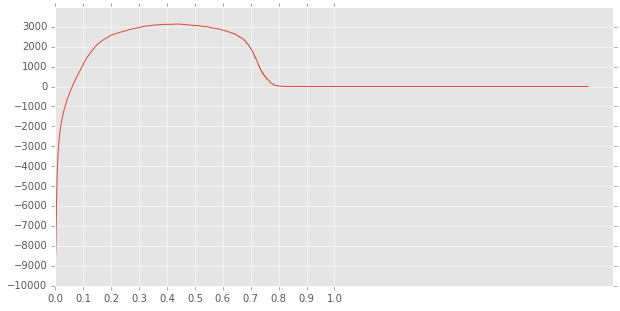

In [120]:
plt.plot(roc.Thresholds,valid_profits)
plt.yticks(xrange(-10000,4000,1000))
_ = plt.xticks(np.linspace(0,1,11))
plt.rc('figure',figsize=(5,5))

from above plot, we know that, the best probability cutoff should be around 0.4, which can proved by following codes

In [116]:
valid_threshold_profits = pd.DataFrame({'threshold':roc.Thresholds,'profit':valid_profits})
temp = valid_threshold_profits.loc[  valid_threshold_profits.profit.argmax()   ,:]
temp

profit       3140.000000
threshold       0.440462
Name: 3297, dtype: float32

In [117]:
proba_threshold = temp['threshold']
proba_threshold

0.44046205

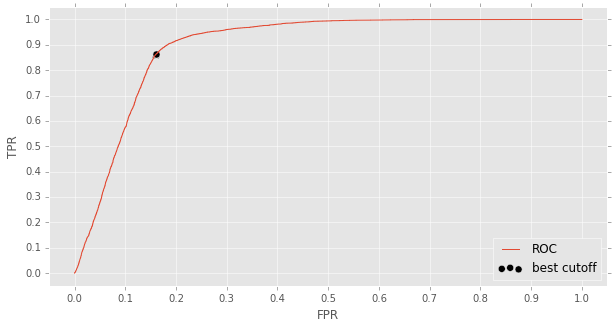

In [144]:
# plot ROC
plt.plot(roc.FPR,roc.TPR,label='ROC')
plt.xlabel("FPR")
plt.ylabel('TPR')

ticks = np.linspace(0,1,11)
plt.yticks(ticks)
plt.xticks(ticks)

# plot best thresholds
best_cutoffs = roc.loc[ (roc.Thresholds > 0.43) & (roc.Thresholds < 0.44),:]
plt.scatter(best_cutoffs.FPR,best_cutoffs.TPR,c='k',s=50,label='best cutoff')

plt.rc('figure',figsize=(10,5))
plt.legend(loc='best')

## Re-train the model with all training data

combine training data and validation set together, train with the best parameters found. this can improve the model.

In [121]:
# combine training set and validation set together
Xalltrain = pd.concat([Xtrain,Xvalid],axis=0)
yalltrain = pd.concat([ytrain,yvalid],axis=0)
alltrain_matrix = xgb.DMatrix(Xalltrain,yalltrain)

In [123]:
# check the parameters
params

{'colsample_bytree': 0.8,
 'early_stop_rounds': 30,
 'eta': 0.1,
 'eval_metric': 'auc',
 'max_depth': 6,
 'num_rounds': 300,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.8}

In [126]:
# best number of trees
n_trees

74

In [127]:
watchlist = [(alltrain_matrix, 'train')]
all_bst = xgb.train(params, alltrain_matrix, n_trees,watchlist)

[0]	train-auc:0.888415
[1]	train-auc:0.892295
[2]	train-auc:0.894753
[3]	train-auc:0.894885
[4]	train-auc:0.895281
[5]	train-auc:0.895747
[6]	train-auc:0.896952
[7]	train-auc:0.897795
[8]	train-auc:0.898369
[9]	train-auc:0.898528
[10]	train-auc:0.898974
[11]	train-auc:0.899198
[12]	train-auc:0.899613
[13]	train-auc:0.89992
[14]	train-auc:0.900229
[15]	train-auc:0.900323
[16]	train-auc:0.900609
[17]	train-auc:0.900917
[18]	train-auc:0.90116
[19]	train-auc:0.901616
[20]	train-auc:0.90223
[21]	train-auc:0.902498
[22]	train-auc:0.902791
[23]	train-auc:0.903069
[24]	train-auc:0.903262
[25]	train-auc:0.903646
[26]	train-auc:0.903862
[27]	train-auc:0.904081
[28]	train-auc:0.904212
[29]	train-auc:0.904196
[30]	train-auc:0.904578
[31]	train-auc:0.905001
[32]	train-auc:0.905515
[33]	train-auc:0.905761
[34]	train-auc:0.905875
[35]	train-auc:0.906026
[36]	train-auc:0.90618
[37]	train-auc:0.906323
[38]	train-auc:0.90656
[39]	train-auc:0.906688
[40]	train-auc:0.906947
[41]	train-auc:0.907298
[42]	tr

## Test

In [128]:
ytest_pred_probas = all_bst.predict(test_matrix, ntree_limit=n_trees)
ytest_pred = (ytest_pred_probas > proba_threshold).astype(int)

In [129]:
print "test accuracy: ",accuracy_score(ytest,ytest_pred)

test accuracy:  0.842762940983


In [130]:
print classification_report(ytest,ytest_pred)

             precision    recall  f1-score   support

          0       0.93      0.83      0.88     21161
          1       0.69      0.87      0.77      9169

avg / total       0.86      0.84      0.85     30330



In [132]:
# profit under old model
loan_test = loan.loc[ytest.index,:]
old_profit = loan_test.profit.sum()
old_profit

4130

In [134]:
# profit under new model
new_profit = calc_profits(loan_test.repaid,ytest_pred_probas,proba_threshold)
new_profit

4400

from above result, <span style='color:orange;font-weight:bold;font-size:1.5em'>the model yields a profit as 4130, while my new model can yield a profit as 4400, improved 6.5%.</span>

## Feature importance

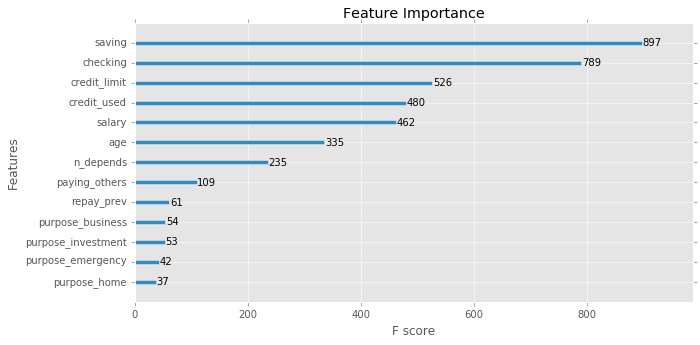

In [146]:
xgb.plot_importance(all_bst,title='Feature Importance')

<a id='q3'></a>** Answer Question 3 **, *"Describe the impact of the most important variables on the prediction. Also, focus on the variable "is_employed", which describes whether the borrower is employed when she asks for the loan. How does this variable impact the model? Explain why"*

according to above plot, the most important feature is 'saving amount'. This makes perfect sense. Money in the saving account, meaure a person's ability to control his financial situation. More money in the saving account, more likely the borrower can repay.

as I mentioned, in my model, 'is_employed' is merged into feature 'salary', which correspond to the case 'salary=0'. according to above plot, salary is also a strong feature. 
* if not employed, then salary=0, which will impact negatively on 'grant decision'. that is very easy to understand, a person without any financial input, will be very unlikely to repay.
* but even the person is employed, whether grant the loan or not, depends on his salary. higher salary indicates strong ability to repay.

## Extra useful features
** Answer Question 4: ** * "Are there any other variables, not in the data provided, that you'd have liked to include in the model?" *

some useful feature which may include:
1. marriage status. 
    * Because even a borrow cannot repay, if he/she is married, his/her spouse can help to repay.
2. housing status, has his/her own house, or rent appartments? if renting, how much is monthly rent?
    * Because even the borrower cannot repay, if he/she has house, the house can be sold to repay the debt
3. educational level
    * normally a person who received higher education, has stronger capability to earn money to repay, and has higher moral standard to repay.